In [1]:
import numpy as np
import pandas as pd

import scipy
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb

import sklearn
# from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from sklearn.preprocessing import scale

In [2]:
# Configure the output
np.set_printoptions(precision=4,suppress=True)
%matplotlib inline
rcParams["figure.figsize"] =20,10
sb.set_style("whitegrid")

In [ ]:
# read_csv to get distance scores of each sentence pair.

In [4]:
df_clean = df.loc[df['score'] != 'na']
df_clean.describe()

NameError: name 'df' is not defined

In [ ]:
df_clean = df_clean.copy()
df_clean['dist'] = df_clean['score'].astype(int)
df_clean.head()

In [ ]:
df_clean = df_clean.drop(columns=['score'])
df_clean.head()

In [ ]:
df_clean.describe()

### import from csv instead.

In [37]:
df_clean = pd.read_csv("../data/roberta/Astro1_decomposed_clean_pairs_roberta_distances.csv")
df_pairs = pd.read_csv("../data/Astro1_decomposed_clean_pairs.csv")
display(df_clean.head(), df_pairs.head())

,Unnamed: 0,predicted_class,C,N,E,dist
0,0,neutral,0.022798,0.880442,0.096760,0.450491
1,1,entailment,0.001746,0.039801,0.958454,0.019935
2,2,neutral,0.004882,0.990273,0.004845,0.497565
3,3,neutral,0.052050,0.944104,0.003846,0.497971
4,4,entailment,0.001493,0.161846,0.836661,0.081044


,Unnamed: 0,first,second
0,0,You never give up.,You never find it difficult to change your min...
1,1,You never give up.,"Whatever you have set your sights on, you refu..."
2,2,You never give up.,You are patient unless someone takes you too far.
3,3,You never give up.,You are usually slow to anger unless someone t...
4,4,You never give up.,You are reliable.


In [38]:
df_clean = df_clean.drop(columns=["Unnamed: 0"])
df_pairs = df_pairs.drop(columns=["Unnamed: 0"])
display(df_clean.head(), df_pairs.head())

,predicted_class,C,N,E,dist
0,neutral,0.022798,0.880442,0.096760,0.450491
1,entailment,0.001746,0.039801,0.958454,0.019935
2,neutral,0.004882,0.990273,0.004845,0.497565
3,neutral,0.052050,0.944104,0.003846,0.497971
4,entailment,0.001493,0.161846,0.836661,0.081044


,first,second
0,You never give up.,You never find it difficult to change your min...
1,You never give up.,"Whatever you have set your sights on, you refu..."
2,You never give up.,You are patient unless someone takes you too far.
3,You never give up.,You are usually slow to anger unless someone t...
4,You never give up.,You are reliable.


In [39]:
df_pairs = df_pairs.assign(dist=df_clean['dist'])

In [40]:
df_pairs.head()

,first,second,dist
0,You never give up.,You never find it difficult to change your min...,0.450491
1,You never give up.,"Whatever you have set your sights on, you refu...",0.019935
2,You never give up.,You are patient unless someone takes you too far.,0.497565
3,You never give up.,You are usually slow to anger unless someone t...,0.497971
4,You never give up.,You are reliable.,0.081044


In [3]:
df_pairs = pd.read_csv("../data/roberta_kg_astro1clean_distances(debugged1).csv")
df_pairs.head()

,Unnamed: 0,first_index,second_index,relation_score,first,second,dist
0,0,0,1,0.000000,You never give up.,You never find it difficult to change your min...,0.500000
1,1,0,2,0.000000,You never give up.,"Whatever you have set your sights on, you refu...",0.500000
2,2,0,3,0.000000,You never give up.,You are patient unless someone takes you too far.,0.500000
3,3,0,4,0.007928,You never give up.,You are usually slow to anger unless someone t...,0.496036
4,4,0,5,-0.416145,You never give up.,You are reliable.,0.708073


### actual processing begins here.

In [41]:
# convert this original dataframe to a 'square' distance matrix.
# we utilise a pivot table to do this

# first, add the redundant pairs (two of the same sentences) to the data.
# we need this for the pivot function to generate the correct rows and columns.
first = np.unique(df_pairs['first'].values)
second = np.unique(df_pairs['second'].values)
combined_arr = np.concatenate((first, second))
sentences = np.unique(combined_arr)
print(len(sentences))

47


In [44]:
#add_data = np.column_stack([np.zeros(len(sentences)), np.zeros(len(sentences)), np.zeros(len(sentences)), np.zeros(len(sentences)), sentences, sentences, np.zeros(len(sentences))])
add_data = np.column_stack([sentences, sentences, np.zeros(len(sentences))])

print(add_data)

[['Debate and argument appeal to you.'
  'Debate and argument appeal to you.' 0.0]
 ['Keeping things going is your strength, especially once someone else starts them.'
  'Keeping things going is your strength, especially once someone else starts them.'
  0.0]
 ['Money and possessions are important to you for the feelings of security they bring.'
  'Money and possessions are important to you for the feelings of security they bring.'
  0.0]
 ['Whatever you have set your sights on, you refuse to give up or let go of it.'
  'Whatever you have set your sights on, you refuse to give up or let go of it.'
  0.0]
 ['You are adventurous.' 'You are adventurous.' 0.0]
 ['You are consistent.' 'You are consistent.' 0.0]
 ['You are courageous.' 'You are courageous.' 0.0]
 ['You are gentle.' 'You are gentle.' 0.0]
 ['You are handy with your hands.' 'You are handy with your hands.' 0.0]
 ['You are independent.' 'You are independent.' 0.0]
 ['You are patient unless someone takes you too far.'
  'You are

In [45]:
add_df = pd.DataFrame(data=add_data, columns=df_pairs.columns)
add_df.head()

,first,second,dist
0,Debate and argument appeal to you.,Debate and argument appeal to you.,0
1,"Keeping things going is your strength, especia...","Keeping things going is your strength, especia...",0
2,Money and possessions are important to you for...,Money and possessions are important to you for...,0
3,"Whatever you have set your sights on, you refu...","Whatever you have set your sights on, you refu...",0
4,You are adventurous.,You are adventurous.,0


In [46]:
df_clean = df_pairs.append(add_df, ignore_index=True)
df_clean.tail()

,first,second,dist
1123,Your work is usually neat.,Your work is usually neat.,0
1124,Your work is usually orderly.,Your work is usually orderly.,0
1125,you dislike dirt.,you dislike dirt.,0
1126,you dislike messes.,you dislike messes.,0
1127,you probably have a good head for numbers.,you probably have a good head for numbers.,0


In [47]:
df_clean.describe()

,first,second,dist
count,1128,1128,1128.0
unique,47,47,1082.0
top,You never give up.,You are romantic.,0.0
freq,47,47,47.0


In [48]:
df_piv = df_clean.pivot("first", "second", "dist").fillna(0)
piv_arr = df_piv.values
dist_mat = piv_arr + np.transpose(piv_arr)

In [49]:
df_piv.describe()

second,Debate and argument appeal to you.,"Keeping things going is your strength, especially once someone else starts them.",Money and possessions are important to you for the feelings of security they bring.,"Whatever you have set your sights on, you refuse to give up or let go of it.",You are adventurous.,You are consistent.,You are courageous.,You are gentle.,You are handy with your hands.,You are independent.,...,You tend to be open-minded.,You tend to be optimistic.,You tend to be versatile.,Your mind is analytical.,Your mind is deep.,Your work is usually neat.,Your work is usually orderly.,you dislike dirt.,you dislike messes.,you probably have a good head for numbers.
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.196148,0.123333,0.135177,0.021636,0.256837,0.052309,0.190179,0.575007,0.134321,0.178960,...,0.442026,0.350686,0.431035,0.289496,0.262598,0.323762,0.311705,0.372356,0.339955,0.282731
std,0.313113,0.234425,0.241722,0.145385,0.359488,0.182777,0.247488,0.284391,0.219837,0.224449,...,0.344035,0.253837,0.323968,0.269090,0.239845,0.272599,0.273486,0.293184,0.258105,0.241734
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.468337,0.000000,0.000000,...,0.028153,0.000000,0.131184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.494866,0.000000,0.000000,...,0.483028,0.492330,0.462751,0.454833,0.421574,0.487719,0.474945,0.486474,0.484460,0.468726
75%,0.484417,0.000000,0.243817,0.000000,0.482075,0.000000,0.471046,0.912830,0.441735,0.480163,...,0.634584,0.497342,0.495555,0.482563,0.490452,0.499241,0.497455,0.498237,0.492131,0.497815
max,0.997179,0.938573,0.938703,0.996945,0.998368,0.997650,0.886855,0.999200,0.499201,0.499352,...,0.996890,0.937826,0.997906,0.973734,0.499499,0.921843,0.984887,0.974492,0.954207,0.499572


In [50]:
for i in range(len(dist_mat)):
    print(dist_mat[i][i])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [51]:
from scipy.spatial.distance import squareform
condensed_mat = squareform(dist_mat)

In [52]:
df_piv.index == df_piv.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [53]:
linkage_arr = linkage(condensed_mat)

In [54]:
linkage_arr

array([[42.    , 43.    ,  0.0025,  2.    ],
       [35.    , 38.    ,  0.0027,  2.    ],
       [30.    , 31.    ,  0.0028,  2.    ],
       [12.    , 32.    ,  0.007 ,  2.    ],
       [23.    , 24.    ,  0.0074,  2.    ],
       [10.    , 18.    ,  0.0077,  2.    ],
       [36.    , 39.    ,  0.0097,  2.    ],
       [ 5.    , 50.    ,  0.0097,  3.    ],
       [16.    , 53.    ,  0.0153,  3.    ],
       [37.    , 48.    ,  0.016 ,  3.    ],
       [55.    , 56.    ,  0.0168,  6.    ],
       [20.    , 51.    ,  0.0176,  3.    ],
       [ 3.    , 29.    ,  0.0199,  2.    ],
       [ 1.    , 58.    ,  0.0227,  4.    ],
       [44.    , 45.    ,  0.024 ,  2.    ],
       [14.    , 15.    ,  0.028 ,  2.    ],
       [54.    , 59.    ,  0.0388,  5.    ],
       [ 4.    ,  6.    ,  0.0391,  2.    ],
       [57.    , 64.    ,  0.0403,  8.    ],
       [13.    , 62.    ,  0.0406,  3.    ],
       [33.    , 65.    ,  0.0469,  9.    ],
       [28.    , 67.    ,  0.0705, 10.    ],
       [11

{'icoord': [[35.0, 35.0, 45.0, 45.0],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [145.0, 145.0, 155.0, 155.0],
  [165.0, 165.0, 175.0, 175.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [195.0, 195.0, 212.5, 212.5],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [285.0, 285.0, 295.0, 295.0],
  [325.0, 325.0, 335.0, 335.0],
  [315.0, 315.0, 330.0, 330.0],
  [345.0, 345.0, 355.0, 355.0],
  [322.5, 322.5, 350.0, 350.0],
  [405.0, 405.0, 415.0, 415.0],
  [395.0, 395.0, 410.0, 410.0],
  [435.0, 435.0, 445.0, 445.0],
  [425.0, 425.0, 440.0, 440.0],
  [402.5, 402.5, 432.5, 432.5],
  [455.0, 455.0, 465.0, 465.0],
  [417.5, 417.5, 460.0, 460.0],
  [385.0, 385.0, 438.75, 438.75],
  [375.0, 375.0, 411.875, 411.875],
  [365.0, 365.0, 393.4375, 393.4375],
  [336.25, 336.25, 379.21875, 379.21875],
  [305.0, 305.0, 357.734375, 357.734375],
  [290.0, 290.0, 331.3671875, 331.3671875],
  [262.5, 262.5, 310.68359375, 310.68359375],
  [245.0, 24

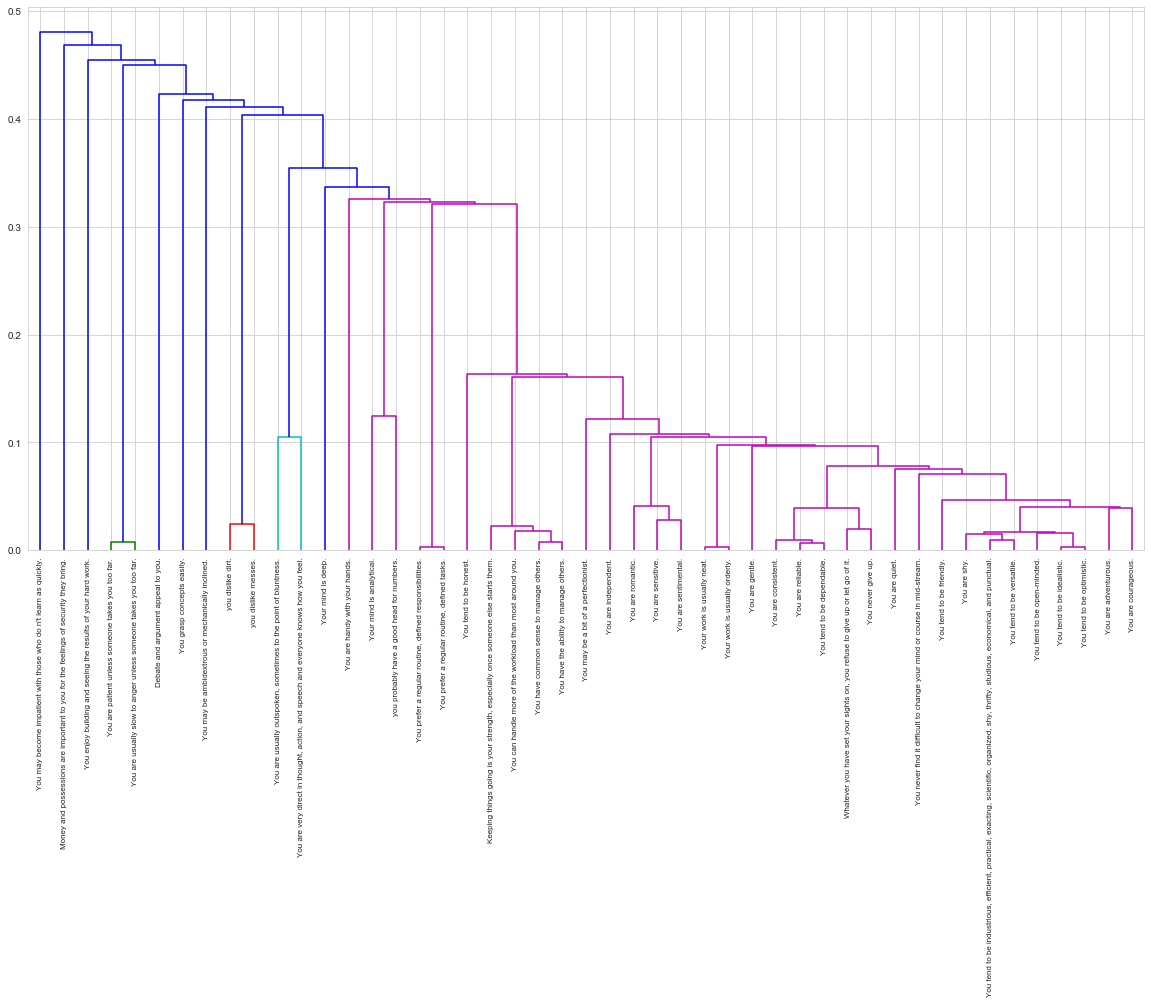

In [55]:
dendrogram(linkage_arr,
            orientation='top',
            labels=df_piv.index.values,
            distance_sort='descending',
            show_leaf_counts=True)

In [56]:
sil_scores = []
for i in range(2, len(dist_mat)):
    clusters = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage='single')
    clusters.fit_predict(dist_mat)

    # use metric to measure/compare goodness of clusters based on internal coherence and 
    # external coupling.
    # consider Dunn index. maximise the Dunn index.
    # or consider average sillhouette width (maximise). available in sklearn.
    from sklearn.metrics import silhouette_score

    silhouette_avg = silhouette_score(dist_mat, clusters.labels_, metric='precomputed')
    sil_scores.append(silhouette_avg)
    print(i, ": ", silhouette_avg)

2 :  -0.026386141861990068
3 :  -0.07634178503972942
4 :  -0.08662385416570807
5 :  -0.044550202156648115
6 :  -0.0485572522606252
7 :  -0.06697209376549114
8 :  -0.08018478485442941
9 :  -0.03872448686682514
10 :  0.006898051887301973
11 :  -0.0001522355683627106
12 :  -0.01058778354698622
13 :  0.026210776009144315
14 :  0.06898521389061772
15 :  0.05310504221942039
16 :  0.09714419976482949
17 :  0.06386050772684418
18 :  0.05517382915094716
19 :  -0.0016760038578212198
20 :  -0.031885998448615796
21 :  0.015192243988690497
22 :  0.05921461511112526
23 :  0.022671357630550313
24 :  0.11762443391931178
25 :  0.13186019645716832
26 :  0.13312050817042526
27 :  0.10358762803470968
28 :  0.11884262292695277
29 :  0.17846276253171162
30 :  0.14140216292701008
31 :  0.2198288117312951
32 :  0.1964562169356423
33 :  0.15624560851188732
34 :  0.14734110582283794
35 :  0.1045681975890694
36 :  0.10683453663587558
37 :  0.23549168836011222
38 :  0.2294325534247196
39 :  0.2652053581922493
40 

In [57]:
sil_scores_arr = np.asarray(sil_scores)
print('max avg silhouette score: ', sil_scores_arr.max())
optimal_k = np.where(sil_scores_arr == sil_scores_arr.max())[0][0] + 2
print('nclusters w max avg silhouette score: ', optimal_k)

max avg silhouette score:  0.2652053581922493
nclusters w max avg silhouette score:  39


In [19]:
clusters = AgglomerativeClustering(n_clusters=optimal_k, affinity='precomputed', linkage='single')
clusters.fit_predict(dist_mat)
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    
    print(f'cluster {i} (size {len(indices)}):')
    print(indices)
    for idx in indices:
        display(df_piv.index[idx])
    print('\n')

cluster 0 (size 2):
[15 36]


'You are sentimental.'

'You tend to be industrious, efficient, practical, exacting, scientific, organized, shy, thrifty, studious, economical, and punctual.'



cluster 1 (size 2):
[ 5 19]


'You are consistent.'

'You are very direct in thought, action, and speech and everyone knows how you feel.'



cluster 2 (size 4):
[22 23 45 46]


'You grasp concepts easily.'

'You have common sense to manage others.'

'you dislike messes.'

'you probably have a good head for numbers.'



cluster 3 (size 6):
[ 2 12 30 31 32 38]


'Money and possessions are important to you for the feelings of security they bring.'

'You are reliable.'

'You prefer a regular routine, defined responsibilities.'

'You prefer a regular routine, defined tasks.'

'You tend to be dependable.'

'You tend to be optimistic.'



cluster 4 (size 7):
[ 1  8  9 20 27 34 43]


'Keeping things going is your strength, especially once someone else starts them.'

'You are handy with your hands.'

'You are independent.'

'You can handle more of the workload than most around you.'

"You may become impatient with those who do n't learn as quickly."

'You tend to be honest.'

'Your work is usually orderly.'



cluster 5 (size 2):
[28 39]


'You never find it difficult to change your mind or course in mid-stream.'

'You tend to be versatile.'



cluster 6 (size 1):
[44]


'you dislike dirt.'



cluster 7 (size 1):
[29]


'You never give up.'



cluster 8 (size 2):
[35 37]


'You tend to be idealistic.'

'You tend to be open-minded.'



cluster 9 (size 1):
[26]


'You may be ambidextrous or mechanically inclined.'



cluster 10 (size 7):
[ 7 14 21 25 40 41 42]


'You are gentle.'

'You are sensitive.'

'You enjoy building and seeing the results of your hard work.'

'You may be a bit of a perfectionist.'

'Your mind is analytical.'

'Your mind is deep.'

'Your work is usually neat.'



cluster 11 (size 1):
[3]


'Whatever you have set your sights on, you refuse to give up or let go of it.'



cluster 12 (size 1):
[16]


'You are shy.'



cluster 13 (size 1):
[6]


'You are courageous.'



cluster 14 (size 1):
[13]


'You are romantic.'



cluster 15 (size 1):
[17]


'You are usually outspoken, sometimes to the point of bluntness.'



cluster 16 (size 1):
[0]


'Debate and argument appeal to you.'



cluster 17 (size 1):
[4]


'You are adventurous.'



cluster 18 (size 1):
[11]


'You are quiet.'



cluster 19 (size 1):
[10]


'You are patient unless someone takes you too far.'



cluster 20 (size 1):
[24]


'You have the ability to manage others.'



cluster 21 (size 1):
[18]


'You are usually slow to anger unless someone takes you too far.'



cluster 22 (size 1):
[33]


'You tend to be friendly.'

In [20]:
import json
# save clusters into JSON dict
clusters_dict = dict()
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    sents = list()
    for idx in indices:
        sents.append(df_piv.index[idx])
    clusters_dict[i] = sents
path = input("enter path to save clusters json file:\n")
with open(path, 'w') as fp:
    json.dump(clusters_dict, fp)

enter path to save clusters json file:
 ../data/Astro1_decomposed_clean_roberta_kg_clusters(debugged).json


In [21]:
# create symmetric pivot df for saving.
df_piv_symmetric = pd.DataFrame(data=dist_mat, index=df_piv.index, columns=df_piv.columns)
df_piv_symmetric.head()

second,Debate and argument appeal to you.,"Keeping things going is your strength, especially once someone else starts them.",Money and possessions are important to you for the feelings of security they bring.,"Whatever you have set your sights on, you refuse to give up or let go of it.",You are adventurous.,You are consistent.,You are courageous.,You are gentle.,You are handy with your hands.,You are independent.,...,You tend to be open-minded.,You tend to be optimistic.,You tend to be versatile.,Your mind is analytical.,Your mind is deep.,Your work is usually neat.,Your work is usually orderly.,you dislike dirt.,you dislike messes.,you probably have a good head for numbers.
first,,,,,,,,,,,,,,,,,,,,,
Debate and argument appeal to you.,0.000000,0.342598,0.500000,0.5,0.479860,0.526780,0.509033,0.559887,0.342598,0.342598,...,0.513946,0.515665,0.5,0.559887,0.559887,0.559887,0.342598,0.244359,0.572312,0.534191
"Keeping things going is your strength, especially once someone else starts them.",0.342598,0.000000,0.286881,0.5,0.454137,0.334438,0.494095,0.404782,0.000000,0.000000,...,0.427410,0.307543,0.5,0.404782,0.404782,0.404782,0.000000,0.414076,0.385027,0.426819
Money and possessions are important to you for the feelings of security they bring.,0.500000,0.286881,0.000000,0.5,0.287063,0.411395,0.489031,0.465043,0.286881,0.286881,...,0.409751,0.046982,0.5,0.465043,0.465043,0.465043,0.286881,0.492211,0.457791,0.452752
"Whatever you have set your sights on, you refuse to give up or let go of it.",0.500000,0.500000,0.500000,0.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
You are adventurous.,0.479860,0.454137,0.287063,0.5,0.000000,0.436454,0.494543,0.401190,0.454137,0.454137,...,0.493530,0.264979,0.5,0.401190,0.401190,0.401190,0.454137,0.481710,0.380690,0.366447


In [22]:
path = input("enter path to save csv file for pairwise distances:\n")
df_piv_symmetric.to_csv(path)

enter path to save csv file for pairwise distances:
 ../data/Astro1_decomposed_clean_roberta_kg_pairwise(debugged).csv


In [23]:
A = "You tend to be dependable."
B = "You are adventurous."
display(df_piv_symmetric.loc[A][B])

0.2870629399854435

### more exploration for choosing "optimal" clusters.

If we use the cutting method on the dengrogram generated much earlier, then we'll end up with 6, 19, 44 or 60 clusters depending on where we cut. However, for the lower number of clusters (e.g. 6 or 19, the cluster sizes are highly imbalanced). We should take a closer look at the contents of the clusters formed.

In [ ]:
for chosen_k in [6, 19, 44, 60]:
    print('------')
    print(f'\n{chosen_k}')
    clusters = AgglomerativeClustering(n_clusters=chosen_k, affinity='precomputed', linkage='single')
    clusters.fit_predict(dist_mat)
    for i in range(clusters.n_clusters_):
        indices = np.where(clusters.labels_ == i)[0]

        print(f'cluster {i} (size {len(indices)}):')
        print(indices)
        for idx in indices:
            display(df_piv.index[idx])
        print('\n')

We could try different linkage algorithms to see their effects too. But we'll leave this for another time.

Let's try visualising (approximately) a graph from the distance matrix:

In [41]:
import networkx as nx
import string

In [42]:
G = nx.from_numpy_matrix(dist_mat)
print(G.nodes())
print(G.edges())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (2, 3), (2, 4), (2

In [43]:
G = nx.from_numpy_matrix(dist_mat)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),string.ascii_uppercase)))

In [45]:
import pydot
from networkx.drawing.nx_pydot import write_dot
print("using package pydot")
path = input("enter path to save dot file:\n")
write_dot(G, path)

using package pydot


enter path to save dot file:
 ../data/viz/Astro1_decomposed_clean_pairs_roberta.dot


Provide generated dotfile to Graphviz neato program for advanced visualisation. Voila!

In [46]:
for i in range(len(df_piv.index)):
    print(i, ' ', df_piv.index[i])

0   Debate and argument appeal to you.
1   Keeping things going is your strength, especially once someone else starts them.
2   Money and possessions are important to you for the feelings of security they bring.
3   Whatever you have set your sights on, you refuse to give up or let go of it.
4   You are adventurous.
5   You are consistent.
6   You are courageous.
7   You are gentle.
8   You are handy with your hands.
9   You are independent.
10   You are patient unless someone takes you too far.
11   You are quiet.
12   You are reliable.
13   You are romantic.
14   You are sensitive.
15   You are sentimental.
16   You are shy.
17   You are usually outspoken, sometimes to the point of bluntness.
18   You are usually slow to anger unless someone takes you too far.
19   You are very direct in thought, action, and speech and everyone knows how you feel.
20   You can handle more of the workload than most around you.
21   You enjoy building and seeing the results of your hard work.
22   You 

I need to find the distances between clusters. to gauge how similar 2 clusters are in relation to one another. I could just use the visualisation tool to visually identify clusters far from each other and try to compare their cluster meanings.

In [47]:
clusters = AgglomerativeClustering(n_clusters=39, affinity='precomputed', linkage='single')
labels = clusters.fit_predict(dist_mat)

from sklearn.metrics import silhouette_samples

silhouette_samples = silhouette_samples(dist_mat, clusters.labels_, metric='precomputed')

print('no. of clusters found:', ' ', clusters.n_clusters_)
print('no. of samples: ', len(silhouette_samples))

for i in range(len(silhouette_samples)):
    print(i, ': ', silhouette_samples[i])

no. of clusters found:   39
no. of samples:  47
0 :  0.0
1 :  0.0
2 :  0.0
3 :  0.0
4 :  0.0
5 :  0.642095879282839
6 :  0.0
7 :  0.0
8 :  0.0
9 :  0.0
10 :  0.9829472362326903
11 :  0.0
12 :  0.8970621816199157
13 :  0.0
14 :  0.0
15 :  0.0
16 :  0.0
17 :  0.0
18 :  0.9836908160481713
19 :  0.0
20 :  0.0
21 :  0.0
22 :  0.0
23 :  0.9825751589154322
24 :  0.5816944135901622
25 :  0.0
26 :  0.0
27 :  0.0
28 :  0.0
29 :  0.0
30 :  0.9937494487658421
31 :  0.9930882383455576
32 :  0.862683660920535
33 :  0.0
34 :  0.0
35 :  0.9331633182778146
36 :  0.36885968477413467
37 :  0.0
38 :  0.8298688456541156
39 :  0.426567938530809
40 :  0.0
41 :  0.0
42 :  0.9931529771934257
43 :  0.9934520368842715
44 :  0.0
45 :  0.0
46 :  0.0


I can write a method to compute the average pairwise distance of one cluster with another cluster.

In [24]:
for n_clusters in [optimal_k]:
    print('------')
    print(f'\nno. of clusters = {n_clusters}')
    clusters = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='single')
    clusters.fit_predict(dist_mat)
    
    # find average distances between clusters and output a new distance matrix
    labels = [i for i in range(clusters.n_clusters_)]
    avg_dist_arr = np.zeros(shape=(clusters.n_clusters_, clusters.n_clusters_))
    for i in range(clusters.n_clusters_):
        indices = np.where(clusters.labels_ == i)[0]
        labels.remove(i)
        for j in labels:
            other_indices = np.where(clusters.labels_ == j)[0]
            intra_dist_arr = np.zeros(shape=(len(indices), len(other_indices)))
            
            for k, index in enumerate(indices):
                for m, other_index in enumerate(other_indices):
                    intra_dist_arr[k][m] = dist_mat[index][other_index]
            
            #print (f'cluster {i} against cluster {j}:')
            #print(intra_dist_arr)
            
            avg_dist = np.average(intra_dist_arr)
            #print(avg_dist)
            avg_dist_arr[i][j] = avg_dist
    print(avg_dist_arr)
        

------

no. of clusters = 23
[[0.     0.3884 0.3207 0.4692 0.483  0.5    0.5258 0.5178 0.4666 0.4303
  0.3572 0.5    0.4702 0.5    0.4784 0.5    0.5    0.4496 0.7327 0.5
  0.3638 0.4891 0.5   ]
 [0.     0.     0.1731 0.322  0.3394 0.5    0.5899 0.6729 0.4689 0.1934
  0.2057 0.5    0.4467 0.4975 0.4137 0.5    0.5399 0.4228 0.7132 0.5
  0.2843 0.4626 0.5   ]
 [0.     0.     0.     0.4538 0.4033 0.5    0.6037 0.5683 0.4499 0.2831
  0.1246 0.5    0.4611 0.4959 0.436  0.5    0.553  0.3759 0.8426 0.5
  0.1535 0.4965 0.5   ]
 [0.     0.     0.     0.     0.2937 0.5    0.4918 0.7189 0.4026 0.2191
  0.4632 0.5    0.5215 0.489  0.3102 0.5    0.5078 0.276  0.5589 0.5
  0.4616 0.4443 0.5   ]
 [0.     0.     0.     0.     0.     0.5    0.4126 0.5693 0.4262 0.3216
  0.4031 0.5    0.3446 0.494  0.4605 0.5    0.3399 0.4533 0.5325 0.5
  0.4501 0.4039 0.5   ]
 [0.     0.     0.     0.     0.     0.     0.5    0.5    0.5    0.5
  0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5
  0.5   

In [ ]:
path = input("enter path to save csv file of inter-cluster distance")
tmp = avg_dist_arr + np.transpose(avg_dist_arr)
np.savetxt(path, tmp, delimiter=",")

In [27]:
# check that distance matrix was generated correctly
i = 1
j = 9
display(tmp[i][j], tmp[j][i])

0.19339425944727745

0.19339425944727745

In [28]:
# get summary statistics of new distance matrix, ignoring the diagonal.
mask = np.ones((clusters.n_clusters_, clusters.n_clusters_), dtype=bool)
np.fill_diagonal(mask, 0)
min_value = tmp[mask].min()
print(min_value)

0.12457158880847503


In [29]:
np.average(tmp[mask])

0.4809812370828172

In [30]:
np.median(tmp[mask])

0.5

In [31]:
np.percentile(tmp[mask], [98, 99, 100])

array([0.7132, 0.7587, 0.8426])

In [32]:
dist_threshold = 0.6  # choose anything further than neutrality.
itr = zip(*np.where(avg_dist_arr > dist_threshold))

# since zip() returns an iterator we should add the elements into a list so that we can loop through the elements again.
# once an iterator has reached its end it cannot be reset.
cluster_pairs = []
count = 0
for pair in itr:
    cluster_pairs.append(pair)
    print(pair)
    count = count+1
print(count)

(0, 18)
(1, 7)
(1, 18)
(2, 6)
(2, 18)
(3, 7)
(6, 10)
(7, 9)
(9, 18)
(10, 12)
(10, 18)
(18, 20)
12


In [33]:
for p in cluster_pairs:
    print(p[0])
    indices = np.where(clusters.labels_ == p[0])
    display(df_piv.index[indices])
    print(p[1])
    indices = np.where(clusters.labels_ == p[1])
    display(df_piv.index[indices])
    print('======')

0


Index(['You are sentimental.', 'You tend to be industrious, efficient, practical, exacting, scientific, organized, shy, thrifty, studious, economical, and punctual.'], dtype='object', name='first')

18


Index(['You are quiet.'], dtype='object', name='first')

1


Index(['You are consistent.', 'You are very direct in thought, action, and speech and everyone knows how you feel.'], dtype='object', name='first')

7


Index(['You never give up.'], dtype='object', name='first')

1


Index(['You are consistent.', 'You are very direct in thought, action, and speech and everyone knows how you feel.'], dtype='object', name='first')

18


Index(['You are quiet.'], dtype='object', name='first')

2


Index(['You grasp concepts easily.', 'You have common sense to manage others.',
       'you dislike messes.', 'you probably have a good head for numbers.'],
      dtype='object', name='first')

6


Index(['you dislike dirt.'], dtype='object', name='first')

2


Index(['You grasp concepts easily.', 'You have common sense to manage others.',
       'you dislike messes.', 'you probably have a good head for numbers.'],
      dtype='object', name='first')

18


Index(['You are quiet.'], dtype='object', name='first')

3


Index(['Money and possessions are important to you for the feelings of security they bring.',
       'You are reliable.',
       'You prefer a regular routine, defined responsibilities.',
       'You prefer a regular routine, defined tasks.',
       'You tend to be dependable.', 'You tend to be optimistic.'],
      dtype='object', name='first')

7


Index(['You never give up.'], dtype='object', name='first')

6


Index(['you dislike dirt.'], dtype='object', name='first')

10


Index(['You are gentle.', 'You are sensitive.',
       'You enjoy building and seeing the results of your hard work.',
       'You may be a bit of a perfectionist.', 'Your mind is analytical.',
       'Your mind is deep.', 'Your work is usually neat.'],
      dtype='object', name='first')

7


Index(['You never give up.'], dtype='object', name='first')

9


Index(['You may be ambidextrous or mechanically inclined.'], dtype='object', name='first')

9


Index(['You may be ambidextrous or mechanically inclined.'], dtype='object', name='first')

18


Index(['You are quiet.'], dtype='object', name='first')

10


Index(['You are gentle.', 'You are sensitive.',
       'You enjoy building and seeing the results of your hard work.',
       'You may be a bit of a perfectionist.', 'Your mind is analytical.',
       'Your mind is deep.', 'Your work is usually neat.'],
      dtype='object', name='first')

12


Index(['You are shy.'], dtype='object', name='first')

10


Index(['You are gentle.', 'You are sensitive.',
       'You enjoy building and seeing the results of your hard work.',
       'You may be a bit of a perfectionist.', 'Your mind is analytical.',
       'Your mind is deep.', 'Your work is usually neat.'],
      dtype='object', name='first')

18


Index(['You are quiet.'], dtype='object', name='first')

18


Index(['You are quiet.'], dtype='object', name='first')

20


Index(['You have the ability to manage others.'], dtype='object', name='first')

### Try HDBSCAN clustering algorithm.

In [60]:
import hdbscan

In [61]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(dist_mat)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='precomputed', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

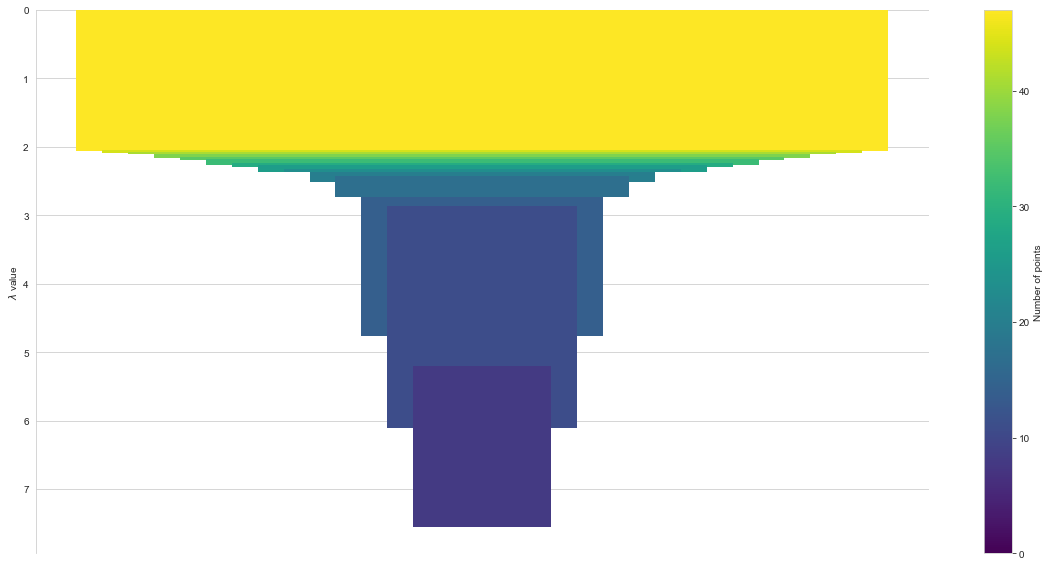

In [62]:
clusterer.condensed_tree_.plot()

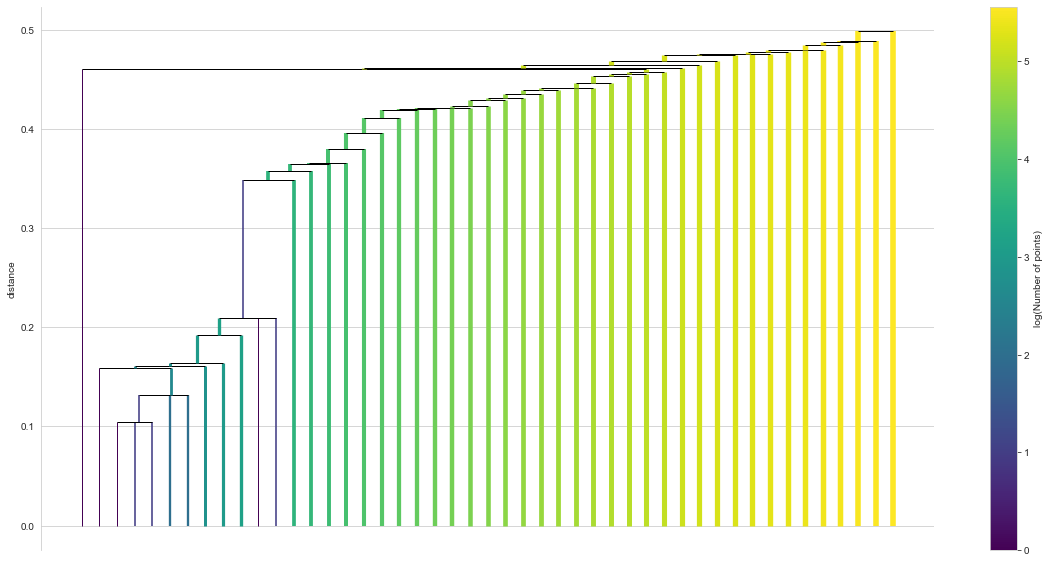

In [63]:
clusterer.single_linkage_tree_.plot()

In [64]:
clusterer.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [65]:
unique, counts = np.unique(clusterer.labels_, return_counts=True)
dict(zip(unique, counts))

{-1: 47}

In [66]:
unique

array([-1], dtype=int64)

In [67]:
for i in unique:
    indices = np.where(clusterer.labels_ == i)[0]

    print(f'cluster {i} (size {len(indices)}):')
    print(indices)
    for idx in indices:
        display(df_piv.index[idx])
    print('\n')

cluster -1 (size 47):
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


'Debate and argument appeal to you.'

'Keeping things going is your strength, especially once someone else starts them.'

'Money and possessions are important to you for the feelings of security they bring.'

'Whatever you have set your sights on, you refuse to give up or let go of it.'

'You are adventurous.'

'You are consistent.'

'You are courageous.'

'You are gentle.'

'You are handy with your hands.'

'You are independent.'

'You are patient unless someone takes you too far.'

'You are quiet.'

'You are reliable.'

'You are romantic.'

'You are sensitive.'

'You are sentimental.'

'You are shy.'

'You are usually outspoken, sometimes to the point of bluntness.'

'You are usually slow to anger unless someone takes you too far.'

'You are very direct in thought, action, and speech and everyone knows how you feel.'

'You can handle more of the workload than most around you.'

'You enjoy building and seeing the results of your hard work.'

'You grasp concepts easily.'

'You have common sense to manage others.'

'You have the ability to manage others.'

'You may be a bit of a perfectionist.'

'You may be ambidextrous or mechanically inclined.'

"You may become impatient with those who do n't learn as quickly."

'You never find it difficult to change your mind or course in mid-stream.'

'You never give up.'

'You prefer a regular routine, defined responsibilities.'

'You prefer a regular routine, defined tasks.'

'You tend to be dependable.'

'You tend to be friendly.'

'You tend to be honest.'

'You tend to be idealistic.'

'You tend to be industrious, efficient, practical, exacting, scientific, organized, shy, thrifty, studious, economical, and punctual.'

'You tend to be open-minded.'

'You tend to be optimistic.'

'You tend to be versatile.'

'Your mind is analytical.'

'Your mind is deep.'

'Your work is usually neat.'

'Your work is usually orderly.'

'you dislike dirt.'

'you dislike messes.'

'you probably have a good head for numbers.'

In [68]:
silhouette_score(dist_mat, clusterer.labels_, metric='precomputed')

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

the optimal clustering from HDBSCAN doesn't seem to have face validity, upon inspection of the sentences in the generated clusters.